# Comprehensive Workflow for ATS Input Generation for Coweeta: Part 2 - Surface/Subsurface Properties and Mesh Extrusion
 
This workflow illustrates the process of developing a simulation campaign for integrated hydrology using ATS.
 
### Overview
 
In Part 2 of this workflow, we focus on mapping datasets onto a mesh to define surface and subsurface properties, documented as labeled sets. The final step involves extruding the mesh into a 3D `m3` mesh object, which is then exported as an Exodus file.

### Datasets Used
 
- `NLCD`: land cover/transpiration/rooting depths
- `MODIS`: LAI
- `GLYHMPS`: geology data for structural formations
- `Pelletier`: depth to bedrock and soil texture information
- `SSURGO`: soil data, where available, in the top 2m.


In [96]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
## FIX ME -- why is this broken without importing netcdf first?
import netCDF4

In [98]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [ ]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import cftime, datetime


import watershed_workflow.io
import watershed_workflow.land_cover_properties
import watershed_workflow.regions
# import watershed_workflow.sources.standard_names as names
pd.options.display.max_columns = None

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)


In [100]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())

# # REMOVE THIS PORTION OF THE CELL for general use outside of Coweeta -- this is just locating 
# # the working directory within the WW directory structure
# if cwd[-1] == 'Coweeta':
#     pass
# elif cwd[-1] == 'examples':
#     cwd.append('Coweeta')
# else:
#     cwd.extend(['examples','Coweeta'])
# # END REMOVE THIS PORTION

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
def toOutput(filename):
    return os.path.join(output_dir, filename)

work_dir = os.path.join(*cwd)
def toWorkingDir(filename):
    return os.path.join(work_dir, filename)
       

In [101]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)

In [102]:
name = 'Coweeta'

# Simulation control
# - note that we use the NoLeap calendar, same as DayMet.  Simulations are typically run over the "water year"
#   which starts August 1.
start = cftime.DatetimeNoLeap(2010,8,1)
end = cftime.DatetimeNoLeap(2011,8,1)

nyears_cyclic_steadystate = 4   # how many years to run spinup

# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils


In [103]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus HR']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# DELETE THIS SECTION for non-Coweeta runs
dtb_file = os.path.join(data_dir, 'DTB', 'DTB.tif')
geo_file = os.path.join(data_dir, 'GLHYMPS', 'GLHYMPS.shp')

# GLHYMPs is a several-GB download, so we have sliced it and included the slice here
sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS(geo_file)

# The Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.
# Here we will use a clipped version of that map.
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster(dtb_file)

# END DELETE THIS SECTION

# log the sources that will be used here
watershed_workflow.source_list.logSources(sources)


2025-08-20 15:13:29,232 - root - INFO: Using sources:
2025-08-20 15:13:29,233 - root - INFO: --------------
2025-08-20 15:13:29,233 - root - INFO: HUC: WBD
2025-08-20 15:13:29,233 - root - INFO: hydrography: NHDPlus HR
2025-08-20 15:13:29,234 - root - INFO: DEM: 3DEP
2025-08-20 15:13:29,234 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-08-20 15:13:29,234 - root - INFO: geologic structure: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/input_data/GLHYMPS/GLHYMPS.shp
2025-08-20 15:13:29,235 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2021_cover_L48
2025-08-20 15:13:29,235 - root - INFO: LAI: MODIS
2025-08-20 15:13:29,235 - root - INFO: depth to bedrock: raster
2025-08-20 15:13:29,236 - root - INFO: meteorology: DayMet 1km


In [104]:
# a dictionary of output_filenames -- will include all filenames generated
output_filenames = {}

In [105]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

### Load Pickle Files from Part 1

In [106]:
intermediate_dir = './intermediate_files/'

# Load the parquet file
rivers = pd.read_parquet(f'{intermediate_dir}rivers.parquet')

# Load the pickle files
with open(f'{intermediate_dir}m2.pkl', 'rb') as file:
    m2 = pickle.load(file)

with open(f'{intermediate_dir}watershed.pkl', 'rb') as file:
    watershed = pickle.load(file)

# Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [107]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-08-20 15:13:29,379 - root - INFO: Found land cover dtypes: uint8
2025-08-20 15:13:29,381 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(127)}


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(127)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (1.0, 1.0, 1.0)]


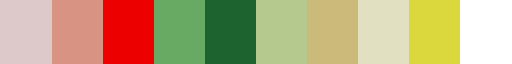

In [108]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

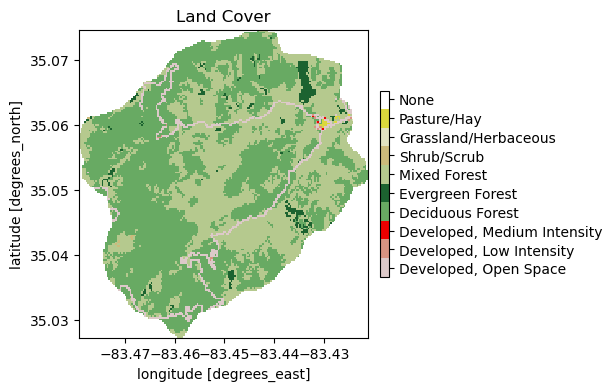

In [109]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
ax.set_title('Land Cover')
plt.show()

In [110]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})

In [111]:
# double-check that nan not in the values
assert 127 not in m2_nlcd

# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))

making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.85882352941, 0.84705882353, 0.23921568628)]


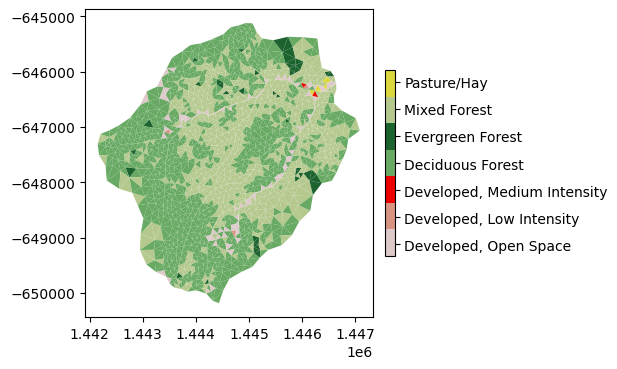

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, colorbar=False, ax=ax)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
plt.show()

In [113]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [114]:
nlcd_labels_dict

{np.uint8(21): 'Developed, Open Space',
 np.uint8(22): 'Developed, Low Intensity',
 np.uint8(23): 'Developed, Medium Intensity',
 np.uint8(41): 'Deciduous Forest',
 np.uint8(42): 'Evergreen Forest',
 np.uint8(43): 'Mixed Forest',
 np.uint8(81): 'Pasture/Hay'}

In [115]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 2593 : "Coweeta Hydrologic Lab"
10001 : CELL : 2593 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 76 : "Coweeta Hydrologic Lab boundary"
10003 : FACE : 5 : "Coweeta Hydrologic Lab outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 184 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 46 : "stream order 2"
10008 : CELL : 122 : "stream order 1"
21 : CELL : 102 : "Developed, Open Space"
22 : CELL : 3 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 1345 : "Deciduous Forest"
42 : CELL : 43 : "Evergreen Forest"
43 : CELL : 1092 : "Mixed Forest"
81 : CELL : 6 : "Pasture/Hay"


## MODIS LAI

Leaf area index is needed on each land cover type -- this is used in the Evapotranspiration calculation.

In [116]:
# download LAI and corresponding LULC datasets -- these are actually already downloaded, 
# as the MODIS AppEEARS API is quite slow
#
# Note that MODIS does NOT work with the noleap calendar, so we have to convert to actual dates first
start_leap = datetime.date(start.year, start.month, start.day)
end_leap = datetime.date(end.year, end.month, end.day)
res = sources['LAI'].getDataset(watershed.exterior, crs, start_leap, end_leap)


2025-08-20 15:13:29,762 - root - INFO: ... searching for: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/input_data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2011_35.0889x-83.4943_35.0133x-83.408.nc
2025-08-20 15:13:29,762 - root - INFO: ... searching for: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/input_data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2011_35.0889x-83.4943_35.0133x-83.408.nc


In [117]:
if isinstance(res, watershed_workflow.sources.manager_modis_appeears.Task):
    assert sources['LAI'].is_ready(res)
    modis_data = sources['LAI'].getDataset(task=res)
else:
    modis_data = res

assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float32


In [118]:
# remove leap day (366th day of any leap year) to match our Noleap Calendar
for k,v in modis_data.items():
    modis_data[k] = watershed_workflow.data.filterLeapDay(v)


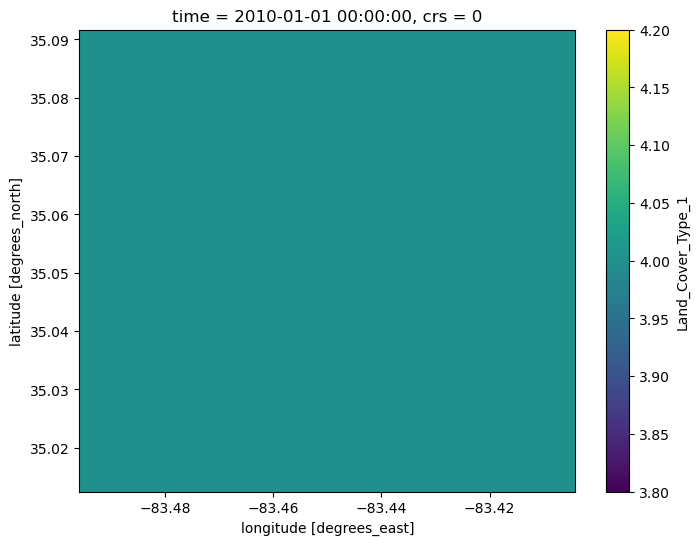

In [119]:
# plot the MODIS data -- note the entire domain is covered with one type for Coweeta (it is small!)
modis_data['LULC'][0].plot.imshow()

In [120]:
# compute the transient time series
modis_lai = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [121]:
modis_lai

,time [datetime],Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.243011
1,2010-08-05 00:00:00,4.847312
2,2010-08-09 00:00:00,3.476344
3,2010-08-13 00:00:00,4.193548
4,2010-08-17 00:00:00,3.186022
...,...,...
88,2011-07-16 00:00:00,6.363441
89,2011-07-20 00:00:00,4.729032
90,2011-07-24 00:00:00,4.132258
91,2011-07-28 00:00:00,5.263441


2025-08-20 15:13:30,028 - root - INFO: Writing HDF5 file: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_transient.h5


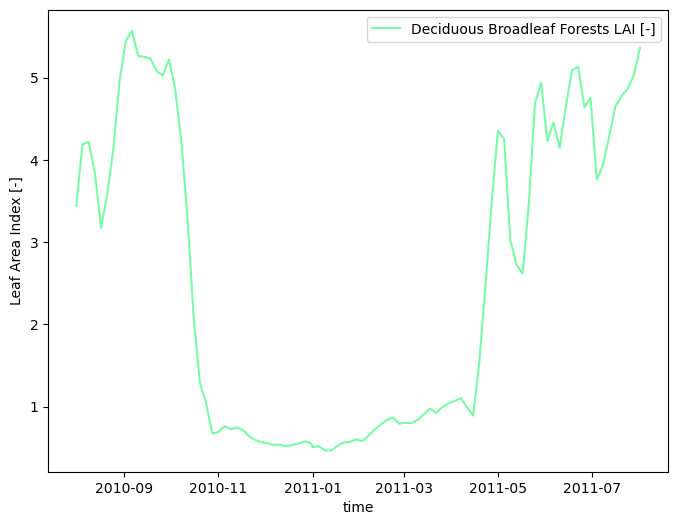

In [122]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai, 'time [datetime]')

# save the MODIS time series to disk
output_filenames['modis_lai_transient'] = toOutput(f'{name}_LAI_MODIS_transient.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_transient'], modis_lai_smoothed)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS')

2025-08-20 15:13:30,127 - root - INFO: Writing HDF5 file: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5


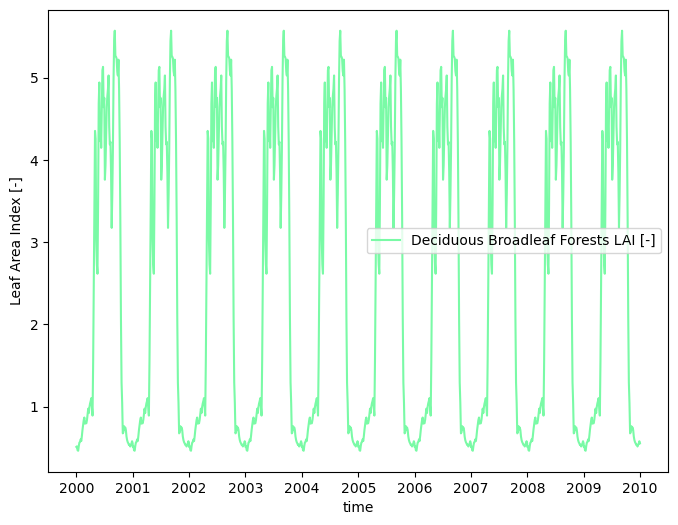

In [123]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed, 'time [datetime]', output_nyears=10, 
                                                                  start_year=2000)

output_filenames['modis_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_MODIS_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_cyclic_steadystate'], modis_lai_typical)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS')

## Crosswalk of LAI to NLCD LC

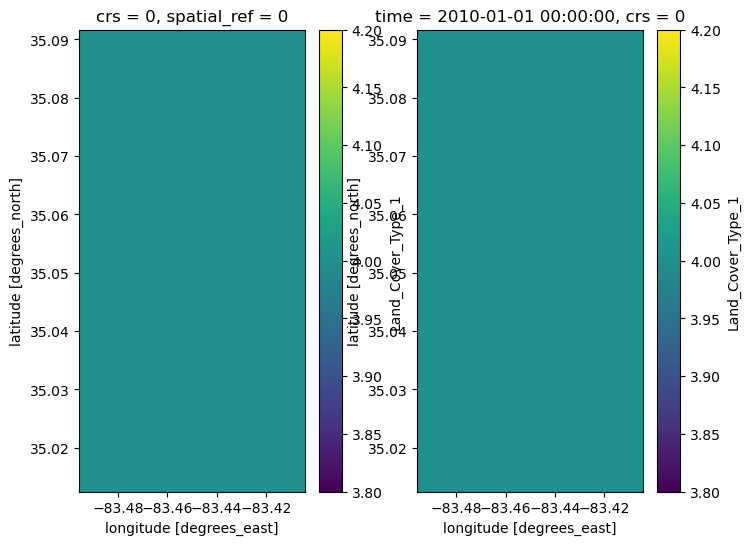

In [124]:
modis_lulc_mode = watershed_workflow.data.computeMode(modis_data['LULC'])

fig, ax = plt.subplots(1,2)
modis_lulc_mode.plot.imshow(ax=ax[0])
modis_data['LULC'][0].plot.imshow(ax=ax[1])
plt.show()

2025-08-20 15:13:30,388 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-08-20 15:13:30,388 - root - INFO:   unique MODIS: [np.float64(4.0)]
2025-08-20 15:13:30,389 - root - INFO:   unique NLCD: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81)]


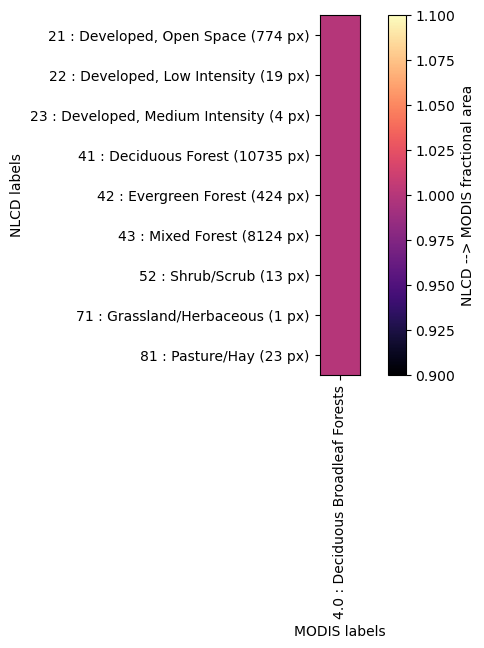

In [125]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_lulc_mode, nlcd, method='fractional area')

In [126]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
nlcd_lai_transient = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_smoothed)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_transient)
nlcd_lai_transient

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time [datetime],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-]
0,2010-08-01 00:00:00,3.441091,3.441091,0.0,3.441091,3.441091,3.441091,3.441091,3.441091,3.441091
1,2010-08-05 00:00:00,4.188735,4.188735,0.0,4.188735,4.188735,4.188735,4.188735,4.188735,4.188735
2,2010-08-09 00:00:00,4.219150,4.219150,0.0,4.219150,4.219150,4.219150,4.219150,4.219150,4.219150
3,2010-08-13 00:00:00,3.846493,3.846493,0.0,3.846493,3.846493,3.846493,3.846493,3.846493,3.846493
4,2010-08-17 00:00:00,3.173528,3.173528,0.0,3.173528,3.173528,3.173528,3.173528,3.173528,3.173528
...,...,...,...,...,...,...,...,...,...,...
88,2011-07-16 00:00:00,4.643113,4.643113,0.0,4.643113,4.643113,4.643113,4.643113,4.643113,4.643113
89,2011-07-20 00:00:00,4.774706,4.774706,0.0,4.774706,4.774706,4.774706,4.774706,4.774706,4.774706
90,2011-07-24 00:00:00,4.864055,4.864055,0.0,4.864055,4.864055,4.864055,4.864055,4.864055,4.864055
91,2011-07-28 00:00:00,5.026882,5.026882,0.0,5.026882,5.026882,5.026882,5.026882,5.026882,5.026882


In [127]:
# write the NLCD-based time series to disk
output_filenames['nlcd_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_NLCD_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_cyclic_steadystate'], nlcd_lai_cyclic_steadystate)

output_filenames['nlcd_lai_transient'] = toOutput(f'{name}_LAI_NLCD_{start.year}_{end.year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_transient'], nlcd_lai_transient)

2025-08-20 15:13:30,507 - root - INFO: Writing HDF5 file: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5
2025-08-20 15:13:30,512 - root - INFO: Writing HDF5 file: /Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_2010_2011.h5


# Subsurface Soil, Geologic Structure

## NRCS Soils

In [128]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs).to_crs(crs)


2025-08-20 15:13:30,538 - root - INFO: Attempting to download source for target '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/input_data/soil_structure/SSURGO/SSURGO_-83.4782_35.0281_-83.4222_35.0738.shp'
2025-08-20 15:13:30,543 - root - INFO:   Found 451 shapes.
2025-08-20 15:13:30,592 - root - INFO: found 41 unique MUKEYs.
2025-08-20 15:13:30,864 - root - INFO: Running Rosetta for van Genutchen parameters
2025-08-20 15:13:30,930 - root - INFO:   ... done
2025-08-20 15:13:30,931 - root - INFO:   requested 41 values
2025-08-20 15:13:30,931 - root - INFO:   got 41 responses


In [129]:
nrcs

,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,545800,"MULTIPOLYGON (((1444314.129 -650192.09, 144430...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800,NRCS-545800
1,545801,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801,NRCS-545801
2,545803,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803,NRCS-545803
3,545805,"MULTIPOLYGON (((1447100.948 -649624.399, 14470...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805,NRCS-545805
4,545806,"MULTIPOLYGON (((1447037.375 -649605.784, 14470...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806,NRCS-545806
5,545807,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807,NRCS-545807
6,545811,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811,NRCS-545811
7,545812,"POLYGON ((1443088.752 -650445.293, 1443072.215...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812,NRCS-545812
8,545813,"MULTIPOLYGON (((1445774.213 -649852.359, 14457...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813,NRCS-545813
9,545814,"MULTIPOLYGON (((1444181.875 -650223.862, 14441...",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814,NRCS-545814


In [130]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [131]:
# Compute the soil color of each cell of the mesh
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'ID', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('ID', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.ID, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


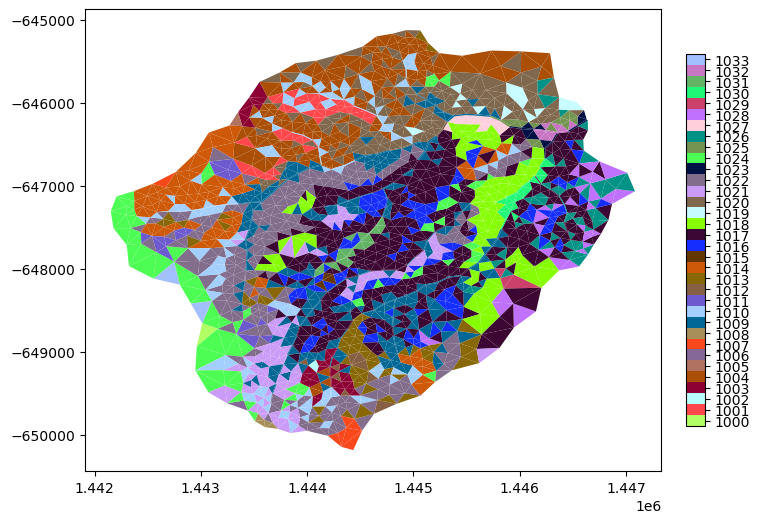

In [132]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from SoilGrids

In [133]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

In [134]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


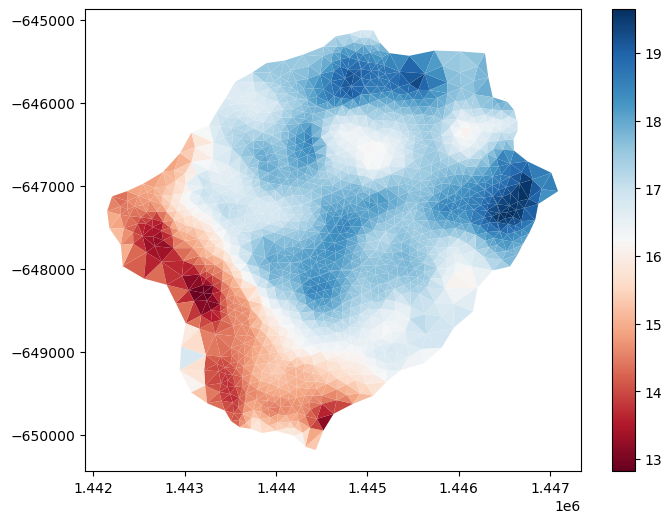

In [135]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [136]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, 
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# convert to the right geometry (this should be done in a call to ww.getShapesByGeometry()!
glhymps = glhymps.to_crs(watershed.crs)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [137]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [138]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [139]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [140]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [141]:
geology_color_glhymps.min()

np.int64(0)

## Combine to form a complete subsurface dataset

In [142]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
output_filenames['subsurface_properties'] = toOutput(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(output_filenames['subsurface_properties'])
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444314.129 -650192.09, 144430...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447100.948 -649624.399, 14470...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447037.375 -649605.784, 14470...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445774.213 -649852.359, 14457...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1444181.875 -650223.862, 14441...",545814.0,2.03
1008,545815,NRCS-545815,NRCS,3.794887e-14,0.319402,0.000162,1.498482,0.177808,"MULTIPOLYGON (((1444243.599 -650184.865, 14442...",545815.0,2.03


# Extrude the 2D Mesh to make a 3D mesh

In [143]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 19.65074688662983 m


In [144]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05252036 0.06479527 0.09181838 0.14694819 0.25946146 0.39251928
 0.49439017 0.49754689]
2.0


In [145]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [146]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[ 2.71470626  5.85798457  9.42730917 10.         10.         10.        ]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [147]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


2025-08-20 15:13:32,149 - root - INFO: Cell summary:
2025-08-20 15:13:32,150 - root - INFO: ------------------------------------------------------------
2025-08-20 15:13:32,150 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-08-20 15:13:32,150 - root - INFO: ------------------------------------------------------------
2025-08-20 15:13:32,150 - root - INFO:  00 	| 00 	| 1008 	|   0.050000 	|   0.000000
2025-08-20 15:13:32,151 - root - INFO:  01 	| 01 	| 1008 	|   0.050000 	|   0.050000
2025-08-20 15:13:32,151 - root - INFO:  02 	| 02 	| 1008 	|   0.050000 	|   0.100000
2025-08-20 15:13:32,151 - root - INFO:  03 	| 03 	| 1008 	|   0.120000 	|   0.150000
2025-08-20 15:13:32,151 - root - INFO:  04 	| 04 	| 1008 	|   0.230000 	|   0.270000
2025-08-20 15:13:32,151 - root - INFO:  05 	| 05 	| 1008 	|   0.500000 	|   0.500000
2025-08-20 15:13:32,152 - root - INFO:  06 	| 06 	| 1008 	|   0.500000 	|   1.000000
2025-08-20 15:13:32,155 - root - INFO:  07 	| 07 	| 1008 	|   0.500000 	|   1.5

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444314.129 -650192.09, 144430...",545800.0,2.03
1001,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1002,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447100.948 -649624.399, 14470...",545805.0,2.03
1003,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447037.375 -649605.784, 14470...",545806.0,2.03
1004,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1005,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1006,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445774.213 -649852.359, 14457...",545813.0,2.03
1007,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1444181.875 -650223.862, 14441...",545814.0,2.03


In [148]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [149]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
10000 : CELL : 2593 : "Coweeta Hydrologic Lab"
10001 : CELL : 2593 : "Coweeta Hydrologic Lab surface"
10002 : FACE : 76 : "Coweeta Hydrologic Lab boundary"
10003 : FACE : 5 : "Coweeta Hydrologic Lab outlet"
10004 : FACE : 5 : "surface domain outlet"
10005 : CELL : 184 : "river corridor 0 surface"
10006 : CELL : 16 : "stream order 3"
10007 : CELL : 46 : "stream order 2"
10008 : CELL : 122 : "stream order 1"
21 : CELL : 102 : "Developed, Open Space"
22 : CELL : 3 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 1345 : "Deciduous Forest"
42 : CELL : 43 : "Evergreen Forest"
43 : CELL : 1092 : "Mixed Forest"
81 : CELL : 6 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------
10000 : CELL : 38895 : "Coweeta Hydrologic Lab"

Extruded 3D side sets
---------------------
1 : FACE : 2593 : "bottom"
2 : FACE : 2593 : "surface"
3 : FACE : 1140 : "external sides"
10001 : FACE : 2593 : "Coweeta Hydrologic Lab surface"


In [150]:
# # save the mesh to disk
# output_filenames['mesh'] = toOutput(f'{name}.exo')
# try:
#     os.remove(output_filenames['mesh'])
# except FileNotFoundError:
#     pass
# m3.writeExodus(output_filenames['mesh'])

<b> This concludes part 2 of the workflow, where surface and subsurface properties are defined, and the 3D mesh is extruded and labeled. </b>

In [153]:
display(output_filenames)

out_files_path = os.path.join(intermediate_dir, 'output_files.pkl')
with open(out_files_path, 'wb') as f:
    pickle.dump(output_filenames, f)
    
    
print("Intermediate files saved successfully.")

{'modis_lai_transient': '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_transient.h5',
 'modis_lai_cyclic_steadystate': '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5',
 'nlcd_lai_cyclic_steadystate': '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5',
 'nlcd_lai_transient': '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_2010_2011.h5',
 'subsurface_properties': '/Users/7s2/Research/projects/ideas/ATS-short-course-2025/git_repo/ats-short-course/05_model_setup/output_data/Coweeta_subsurface_properties.csv'}

Intermediate files saved successfully.
